# Comparison of strategies

Different coloring strategies lead to different results, but also have different performance. It all depends on preferences, what is the goal. 

If one want visually balanced result, `'balanced'` strategy could be the right choice. It comes with four different modes of balancing - `'count'`, `'area'`, `'distance'`, and `'centroid'`. The first one attempts to balance the number of features per each color, second the area covered by each color, and two last based on the distance between features. Either represented by the geometry itself or its centroid (a bit faster).

Other strategies might be helpful if one wants to minimise number of colors as not all strategies use the same amount in the end. Or they just might look better on your map.

Below is a comparison of performance and the result of each of the strategies supported by `greedy`.

In [33]:
import geopandas as gpd
import pandas as pd
from time import time
import numpy as np
import libpysal
import seaborn as sns
sns.set()

from greedy import greedy

When using `'balanced'` strategy with `'area'`, `'distance'`, or `'centroid'` modes, keep in mind that your data needs to be in projected CRS to obtain correct results. For the simplicity of this comparison, let's pretend that dataset below is (even though it is not).

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Strategies used in `greedy` have two origins - `'balanced'` is ported from QGIS while the rest comes from `networkX`. snippet below generates each option 20x and returns the mean time elapsed together with the number of colors used.

In [28]:
strategies = ['balanced', 'largest_first', 'random_sequential', 'smallest_last',
              'independent_set', 'connected_sequential_bfs', 'connected_sequential_dfs',
              'saturation_largest_first']
balanced_modes = ['count', 'area', 'centroid', 'distance']

times = {}
sw = libpysal.weights.Queen.from_dataframe(
                world, ids=world.index.to_list(), silence_warnings=True
            )
for strategy in strategies:
    if strategy == 'balanced':
        for mode in balanced_modes:
            print(strategy, mode)
            timer = []
            for run in range(20):
                s = time()
                colors = greedy(world, strategy=strategy, balance=mode, sw=sw)
                e = time() - s
                timer.append(e)
            world[strategy + '_' + mode] = colors
            times[strategy + '_' + mode] = np.mean(timer)
            print('time: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')
    else:
        print(strategy)
        timer = []
        for run in range(20):
            s = time()
            colors = greedy(world, strategy=strategy, sw=sw)
            e = time() - s
            timer.append(e)
        world[strategy] = colors
        times[strategy] = np.mean(timer)
        print('time: ', np.mean(timer), 's; ', np.max(colors) + 1, 'colors')

balanced count
time:  0.001084136962890625 s;  5 colors
balanced area
time:  0.040719664096832274 s;  5 colors
balanced centroid
time:  0.6460193037986756 s;  5 colors
balanced distance
time:  1.7454206824302674 s;  5 colors
largest_first
time:  0.00638657808303833 s;  5 colors
random_sequential
time:  0.007817411422729492 s;  6 colors
smallest_last
time:  0.012545084953308106 s;  4 colors
independent_set
time:  0.15774503946304322 s;  5 colors
connected_sequential_bfs
time:  0.010410833358764648 s;  5 colors
connected_sequential_dfs
time:  0.010940515995025634 s;  5 colors
saturation_largest_first
time:  0.03293987512588501 s;  4 colors


As you can see, `smallest_last` and `saturation_largest_first` were able, for this particular dataset, to generate greedy coloring using only 4 colors. If one wants to use higher number than the minimal, `'balanced'` strategy allows setting of `min_colors` to be used.

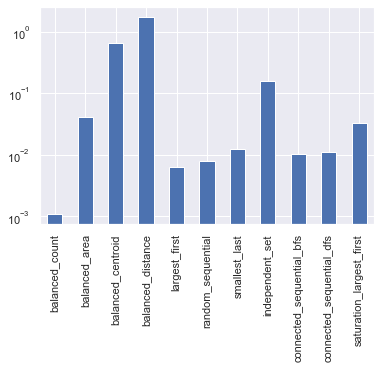

In [36]:
times = pd.Series(times)
ax = times.plot(kind='bar')
ax.set_yscale("log")

Plot above shows the performance of each strategy. Note that the vertical axis is using log scale.

Below are all results plotted on the map.

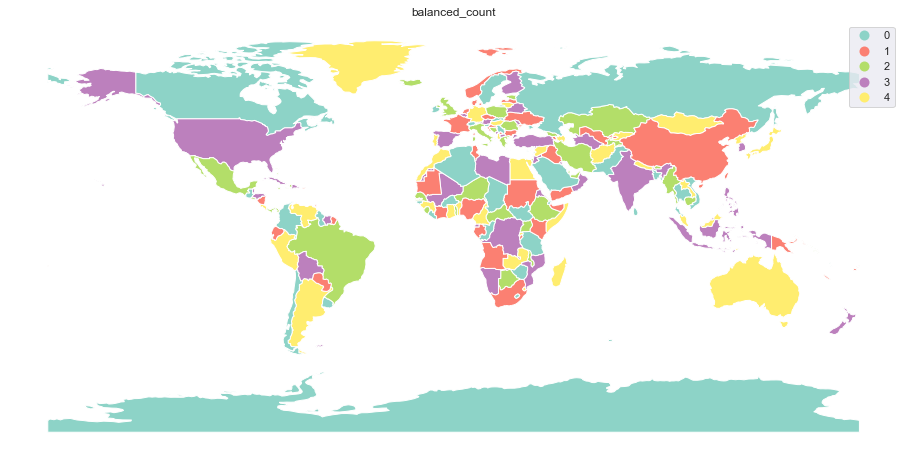

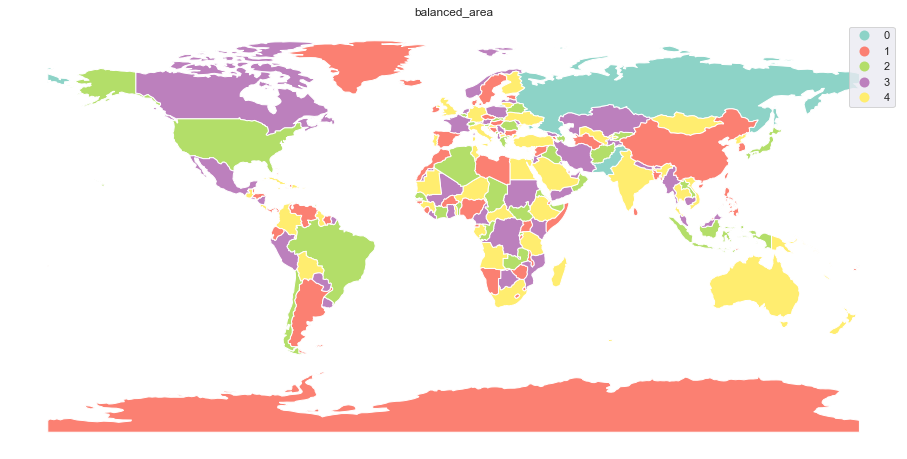

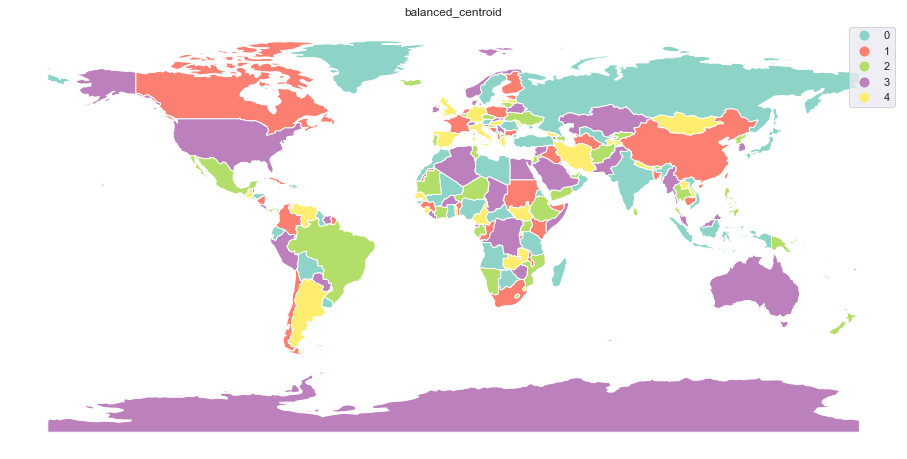

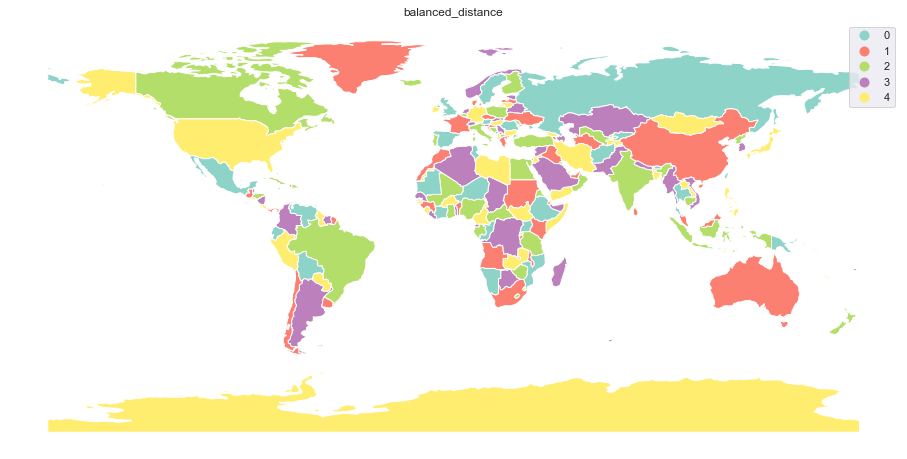

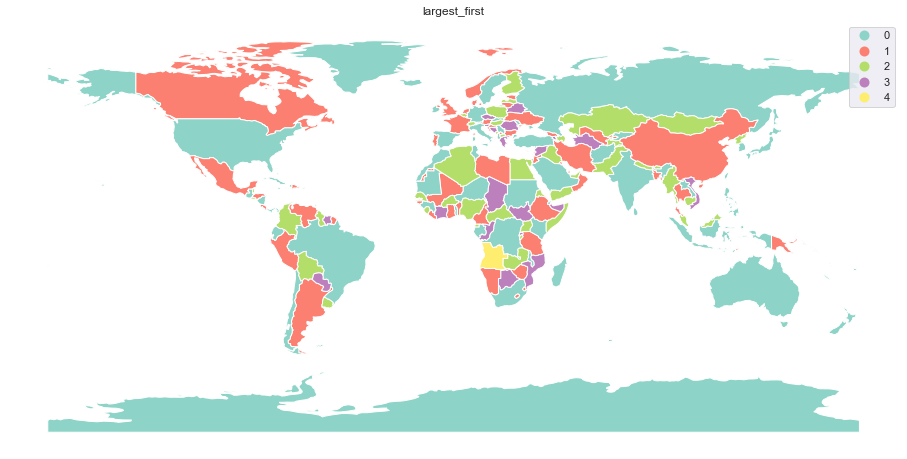

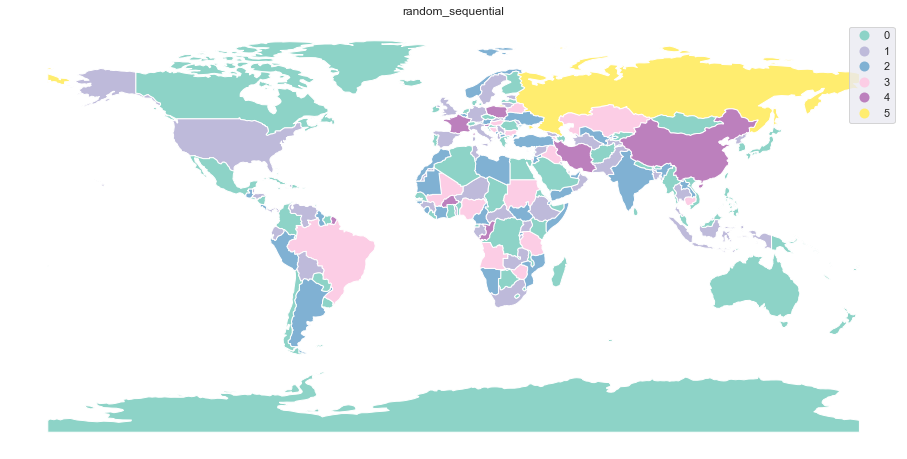

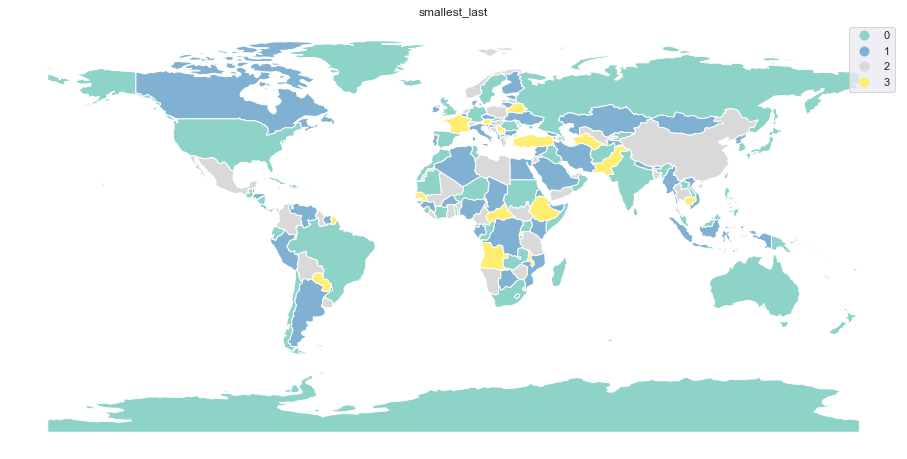

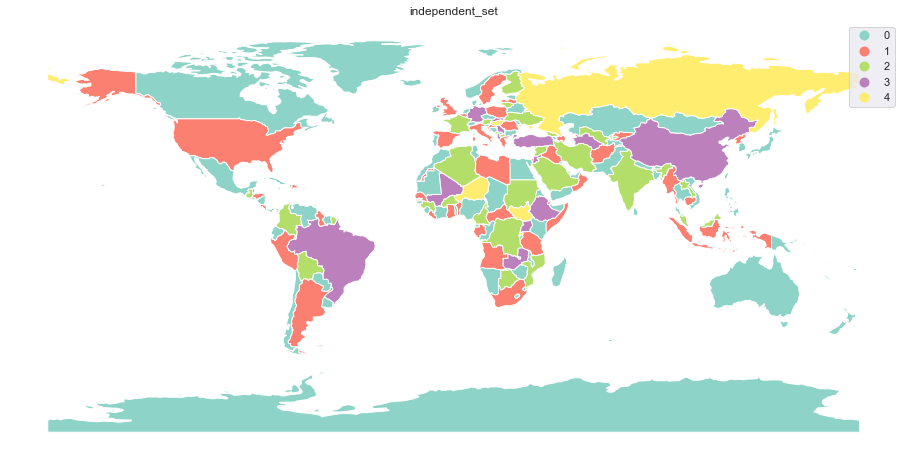

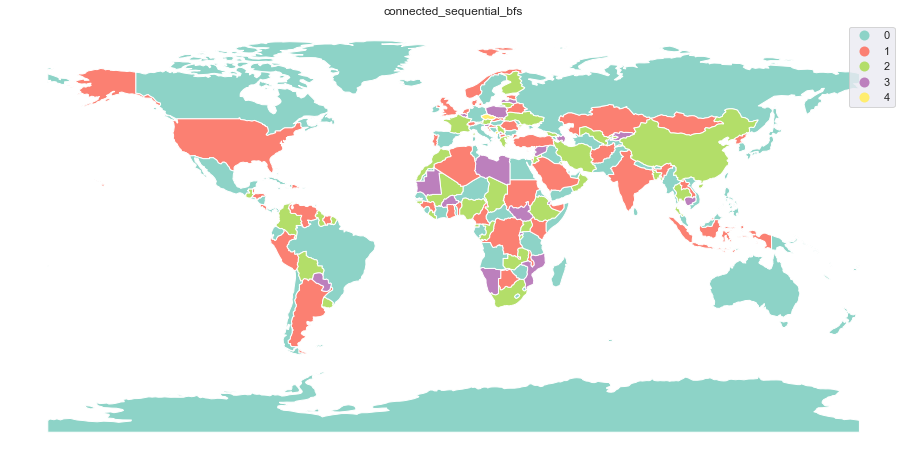

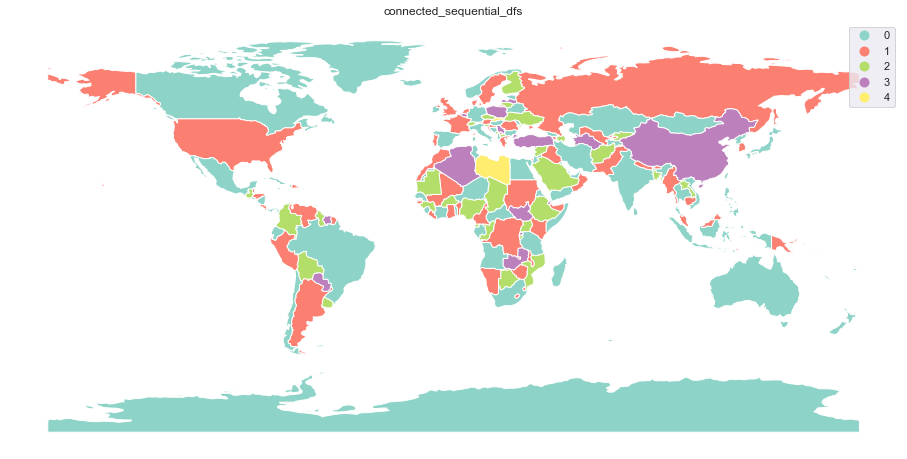

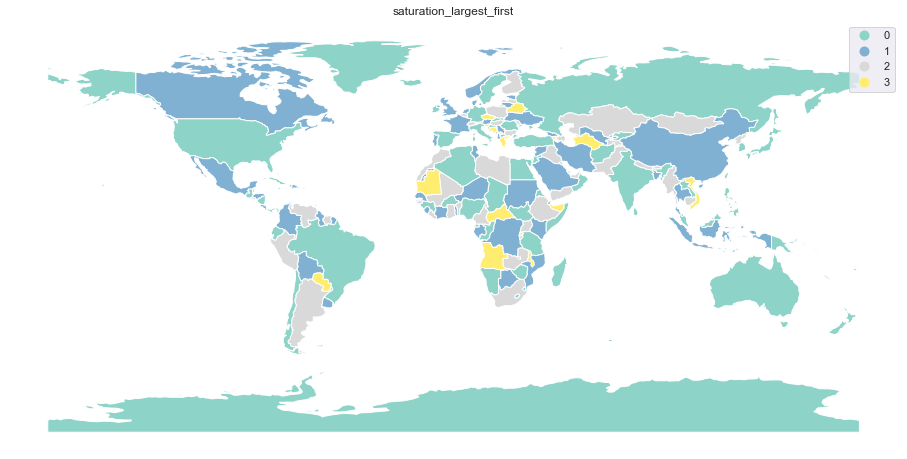

In [40]:
for strategy in times.index:
    ax = world.plot(strategy, categorical=True, figsize=(16, 12), cmap='Set3', legend=True)
    ax.set_axis_off()
    ax.set_title(strategy)